In [2]:
import numpy as np
# !pip install geopy

In [3]:
adj = np.array([[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0], #313772
                [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0], #314548
                [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], #315804
                [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], #317884
                [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1], #317885
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], #318126
                [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0], #318135
                [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], #318142
                [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], #318354
                [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0], #318366
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], #318383
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  #318451
                ])

In [4]:
coors = np.array([[38.57511, -121.53744],
                  [38.57397, -121.57876],
                  [38.60327, -121.54429],
                  [38.58898, -121.55395],
                  [38.58909, -121.55429],
                  [38.57417, -121.5789],
                  [38.57494, -121.57213],
                  [38.57533, -121.57134],
                  [38.57511, -121.5504],
                  [38.57512, -121.54787],
                  [38.57493, -121.54626],
                  [38.57496, -121.5374]
                  ])

In [5]:
# # write a function to compute the distance between two points on the earth, you can use an existing python library geopy
# from geopy.distance import geodesic
# def compute_distance(coord1, coord2):
#     return geodesic(coord1, coord2).km
# def compute_adjacency_matrix(coors):            
#     num_nodes = coors.shape[0]
#     adj_matrix = np.zeros((num_nodes, num_nodes))
#     for i in range(num_nodes):
#         for j in range(num_nodes):
#             if i != j:
#                 distance = compute_distance(coors[i], coors[j])
#                 if distance < 1.0:  # threshold distance in km
#                     adj_matrix[i][j] = 1
#     return adj_matrix
# adj_matrix = compute_adjacency_matrix(coors)
# print(adj_matrix)


In [6]:
# n = len(coors)
# distance_matrix = np.full((n, n), np.inf)

# # Fill in distances for connected nodes
# for i in range(n):
#     for j in range(n):
#         if adj[i][j] == 1:
#             distance_matrix[i][j] = geodesic(coors[i], coors[j]).kilometers
# print(distance_matrix)
# np.savetxt("PEMS03_w12_D.txt", distance_matrix, fmt="%.6f", delimiter=" ")

In [7]:
# Load traffic data
data = np.load('PEMS03.npz')
traffic = data['data']  # shape: (26208, 358, 1)
traffic = traffic.squeeze(axis=-1)  # shape: (26208, 358)

# Load the list of sensor IDs corresponding to the 358 columns
with open('PEMS03.txt', 'r') as f:
    sensor_ids = [int(line.strip()) for line in f]

# The 12 sensor IDs of interest (from your subgraph)
target_ids = [
    313772, 314548, 315804, 317884,
    317885, 318126, 318135, 318142,
    318354, 318366, 318383, 318451
]

# Map sensor ID to column index
sensor_idx_map = {sid: idx for idx, sid in enumerate(sensor_ids)}
target_indices = [sensor_idx_map[sid] for sid in target_ids]

# Extract time-series for these sensors → shape (26208, 12)
selected_data = traffic[:, target_indices]

# Save to text file
print(selected_data.shape)
np.savetxt('PEMS03_w12.txt', selected_data, fmt='%.6f', delimiter=' ')

(26208, 12)


In [10]:
# Generate networkx graph from adjacency matrix and save as gpickle file
import networkx as nx

# Create a directed graph from adjacency matrix
G = nx.DiGraph()

#load the distance matrix
distance_matrix = np.loadtxt("PEMS03_w12_D.txt", delimiter=" ")
n = len(coors)

# Add nodes with coordinates as attributes
for i in range(n):
    G.add_node(i, pos=(coors[i][1], coors[i][0]))  # Note: longitude (x), latitude (y)

# Add edges with distance as weight
for i in range(n):
    for j in range(n):
        if adj[i][j] == 1:
            G.add_edge(i, j, weight=distance_matrix[i][j])

# Save the graph to a gpickle file
import pickle
with open("G_w12.gpickle", "wb") as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
print(f"Graph saved with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph saved with 12 nodes and 33 edges


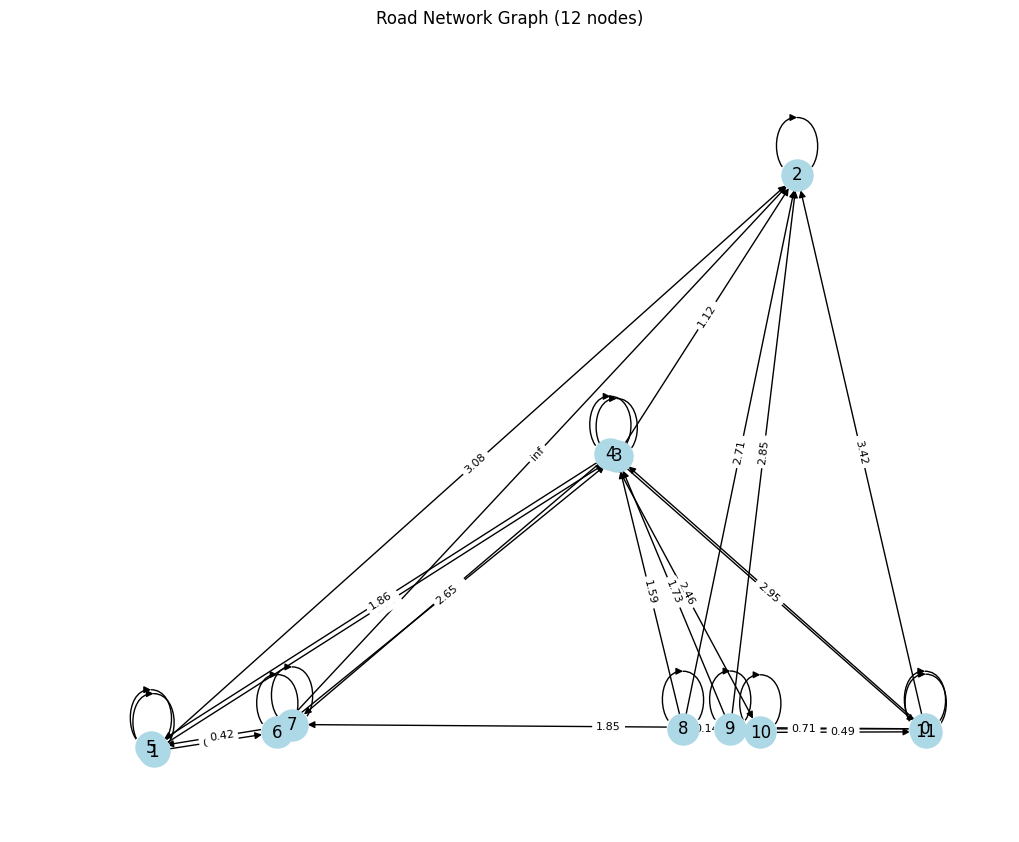

In [11]:
# Visualize the graph to verify it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title('Road Network Graph (12 nodes)')
plt.show()